# Titanic: Machine Learning from Disaster

In [206]:
import pandas as pd

# Read in training and test set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Get a first impression of what kind of data is in the train set
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## From just looking at the first ten rows, it is apparent that:

- PassengerId should be removed
- Surived is the outcome variable and needs to be removed before training the model
- Pclass, Sex and Embarked need to be encoded as categorical features
- Name requires processing to be useful. We can extract whether women were married (by isolating Miss/Mrs) 
- Ticket number may be irrelevant unless it reflects how or where the ticket was purchased. Will isolate number portion and try
- Fare is a numeric predictor and likely important
- Not many passengers have a cabin number, so this may not be worth including

## Datatypes

- The numeric features are already the right datatype
- Categorical features will need to be replaced with dummy codes using OneHotEncoder (for regression)

In [207]:
# Figure out datatypes 
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Distribution and count

- If I decide to use logistic regression, I'll need to scale the features as they have very different distributions
- Looks like there are only 891 data points (and Age has some Nan values) it I should try not replace Nans instead of removing them
- Need to check of there are Nans in the non-numeric columns first


In [208]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## NaN values

- Only Age, Cabin and Embarked are missing values.
- For age, that means 177/891, that's almost 20% missing! I'll have to plot the distribution to determine what to do here
- For Cabin it's 77% NaNs. I will include this as a new categorical feature: whether or not a Cabin is reported
- Since Embarked is only missing 2, I will replace these with the mode

In [209]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Age

- Looks like there are quite a few very young children. This kind of makes sense as they are less likely to be left at school/with a grandparent etc.
- To make sure they are actually children, I will check the name column for these cases below - they seem to all be Miss and Master, so the age info is probably right in these cases
- In general, it seems that using the median of age would be a good replacement for NaN values

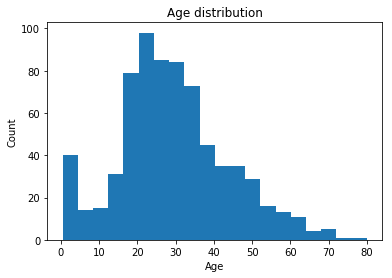

0    24.0
dtype: float64

In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

n, bins, patches = plt.hist(train.Age.dropna(), 20 )
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

train.Age.median()
train.Age.mean()
train.Age.mode()

In [211]:
train[train.Age < 5][['Age','Name']].head(20)
# The girls seems to all be Miss and the boys Master (cute!) so it seems this not a mistake. Let's leave it

,Age,Name
7,2.00,"Palsson, Master. Gosta Leonard"
10,4.00,"Sandstrom, Miss. Marguerite Rut"
16,2.00,"Rice, Master. Eugene"
43,3.00,"Laroche, Miss. Simonne Marie Anne Andree"
63,4.00,"Skoog, Master. Harald"
78,0.83,"Caldwell, Master. Alden Gates"
119,2.00,"Andersson, Miss. Ellis Anna Maria"
164,1.00,"Panula, Master. Eino Viljami"
171,4.00,"Rice, Master. Arthur"
172,1.00,"Johnson, Miss. Eleanor Ileen"


#### Create a copy of train and test datasets to work with and remove PassengerId and Ticket

In [212]:
train_copy = train.copy()
test_copy = test.copy()

del train_copy['PassengerId']
#passengerid = test_copy['PassengerId'].copy()
#train_copy = train_copy.drop(['PassengerId'], axis = 1)

del train_copy['Ticket']
del test_copy['Ticket']

## Categorical features

Next I need to convert Pclass, Sex and Embarked into categorical features. I won't dummy-code them just yet as it is not necessary for Tree-based models (which I'll try first).

#### Convert PClass to categorical feature

In [213]:
train_copy.Pclass = train_copy.Pclass.astype('category')
test_copy.Pclass = test_copy.Pclass.astype('category')

#### Replace null values in Age with median

In [214]:
train_copy.Age = train_copy.Age.fillna(train.Age.median())
test_copy.Age = test_copy.Age.fillna(train.Age.median())

# Confirm that there are no more null values in Age
train_copy.Age.isnull().sum()

0

#### Replace null values in Fare with median

In [215]:
train_copy.Fare = train_copy.Fare.fillna(train.Fare.median())
test_copy.Fare = test_copy.Fare.fillna(train.Fare.median())

# Confirm that there are no more null values in Age
train_copy.Fare.isnull().sum()

0

#### Replace null values in Embarked with mode

In [216]:
# Calculate the mode
embarkmode = train_copy['Embarked'].mode()

# Replace null values with mode (both in train and test) 
train_copy.loc[(train_copy['Embarked'].isnull()), 'Embarked'] = embarkmode.values[0]
test_copy.loc[(test_copy['Embarked'].isnull()), 'Embarked'] = embarkmode.values[0]

# Confirm that there are no more null values in Embarked
train_copy.Embarked.isnull().sum()

# Convert to categorical data type
train_copy.Embarked = train_copy.Embarked.astype('category')
test_copy.Embarked = test_copy.Embarked.astype('category')

#### Convert Cabin feature to 1 for 'has cabin info' vs. 0 for 'has no cabin info'

In [217]:
import re 
regex_pat = re.compile(r'[1-9A-Za-z 0]*') # If Cabin contains any characters at all
train_copy.Cabin = train_copy.Cabin.str.replace(regex_pat, '1') # Replace these with a 1 (string to conform with data type)
test_copy.Cabin = test_copy.Cabin.str.replace(regex_pat, '1') # Do the same for the test set

train_copy.Cabin = train_copy.Cabin.fillna(0) # Replace NaN values in Cabin with 0
test_copy.Cabin = test_copy.Cabin.fillna(0) # Same again for the test set

# Now make it a categorical feature
train_copy.Cabin = train_copy.Cabin.astype('category')
test_copy.Cabin = test_copy.Cabin.astype('category')

#### Convert Sex and Embarked into numeric categorical features

In [218]:
# Function that replaces categorical variables with integers
def replace_with_int(df, column, vals, replacevals):
    for i in range(len(vals)):
        df[column] = df[column].replace(vals[i], replacevals[i])
    return df

train_copy = replace_with_int(train_copy, 'Sex', ['male','female'], [0, 1])
test_copy = replace_with_int(test_copy, 'Sex', ['male','female'], [0, 1])

train_copy = replace_with_int(train_copy, 'Embarked', ['S', 'C', 'Q'], [0, 1, 2])
test_copy = replace_with_int(test_copy, 'Embarked', ['S', 'C', 'Q'], [0, 1, 2])

# Convert categorical variables to category datatype
for col in ['Pclass', 'Sex', 'Cabin', 'Embarked']:
    train_copy[col] = train_copy[col].astype('category')
    test_copy[col] = test_copy[col].astype('category')
    
train_copy['Survived'] = train_copy['Survived'].astype('category')

train_copy.dtypes

Survived    category
Pclass      category
Name          object
Sex         category
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin       category
Embarked    category
dtype: object

## Working with the names

- Try and isolate Miss and Mrs from the name feature as this will give us information about female marital status
- Also, by combining it with the Parents/children feature we can make a good estimate of whether they are mothers/fathers
- While those under 18 who have Parents/children are likely to be accompanied by parents

In [219]:
# First isolate the title using regex
regex_pat = re.compile('(.*, )|(\\..*)')
train_copy['Title'] = train_copy.Name.str.replace(regex_pat, '')
test_copy['Title'] = test_copy.Name.str.replace(regex_pat, '')

# If they are => 18 and Parent/Child column >0 then they are likely to be parents
are_parents_index = train_copy.loc[(train_copy['Age'] >= 18) & (train_copy['Parch'] > 0)].index
train_copy['WithChild'] = 0
train_copy.loc[are_parents_index,'WithChild'] = 1
are_parents_index = test_copy.loc[(test_copy['Age'] >= 18) & (test_copy['Parch'] > 0)].index
test_copy['WithChild'] = 0
test_copy.loc[are_parents_index,'WithChild'] = 1

# Kids that had at least one parent on board
with_parents_index = train_copy.loc[(train_copy['Age'] < 18) & (train_copy['Parch'] >= 1)].index
train_copy['NumOfParents'] = 0
train_copy.loc[with_parents_index, 'NumOfParents'] = 1
with_parents_index = test_copy.loc[(test_copy['Age'] < 18) & (test_copy['Parch'] >= 1)].index
test_copy['NumOfParents'] = 0
test_copy.loc[with_parents_index, 'NumOfParents'] = 1

# If they are >= 18 and have only one Sibling/Spouse on board, they are probably accompanied by their Wife/Husband
with_spouse_index = train_copy.loc[(train_copy['Age'] >= 18) & (train_copy['SibSp'] == 1)].index
train_copy['WithSpouse'] = 0
train_copy.loc[with_spouse_index, 'WithSpouse'] = 1
with_spouse_index = test_copy.loc[(test_copy['Age'] >= 18) & (test_copy['SibSp'] == 1)].index
test_copy['WithSpouse'] = 0
test_copy.loc[with_spouse_index, 'WithSpouse'] = 1

# It seems there are a small number of high-ranking individuals (based on their title)
train_copy['Title'].value_counts()

# Let's lump special titles together since they might not all occur in the test set, 5 seems to be a good cutoff point (doctors might be a good separate group)
special_titles = train_copy['Title'].value_counts()
special_title_list = list(special_titles[special_titles <= 10].index)
train_copy['Title'].replace(special_title_list, 'Special', inplace = True)
special_titles = test_copy['Title'].value_counts()
special_title_list = list(special_titles[special_titles <= 10].index)
test_copy['Title'].replace(special_title_list, 'Special', inplace = True)

# Convert these to numerical values so they can be used as a categorical feature
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_copy['TitleCode'] = le.fit_transform(train_copy['Title'])
test_copy['TitleCode'] = le.fit_transform(test_copy['Title'])

for col in ['TitleCode', 'WithSpouse', 'NumOfParents', 'WithChild']:
    train_copy[col] = train_copy[col].astype('category')
    test_copy[col] = test_copy[col].astype('category')

#### Now remove Name and Title from dataframe

In [220]:
del train_copy['Name']
del train_copy['Title']
del test_copy['Name']
del test_copy['Title']

In [221]:
train_copy.dtypes

Survived        category
Pclass          category
Sex             category
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Cabin           category
Embarked        category
WithChild       category
NumOfParents    category
WithSpouse      category
TitleCode       category
dtype: object

## Prepare model for Random Forest Classification

- Split train set into train/validation sets
- Train model
- Get accuracy score on validation set

In [222]:
# Create X and y
y = train_copy['Survived'].copy()
X = train_copy.drop(['Survived'], axis = 1)

# train/test(/validation) split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [223]:
print(clf.feature_importances_)

[ 0.08513807  0.16063571  0.22800637  0.02261798  0.02633666  0.22943639
  0.04559541  0.04218279  0.01178071  0.00650663  0.01463475  0.12712853]


#### Get accuracy score on training set

- Looks like the model has a fit of 97% on the training set

In [224]:
clf.score(X_train, y_train)

0.97005988023952094

#### Get accuracy score on test/validation set

- For the test set, the accuracy score is almost 79%, which is pretty good!

In [225]:
clf.score(X_test,y_test)

0.7982062780269058

#### Using 5-fold validation, I get an average score of 77% on the whole training set

In [226]:
clf = RandomForestClassifier(random_state=42, n_estimators = 100)
clf.fit(X, y)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv = 5, scoring='precision')

import numpy as np
np.mean(scores)

0.77027755957056809

#### Get test-predictions for Kaggle submission

In [250]:
#passengerid = test_copy['PassengerId'].copy()
#test_copy = test_copy.drop(['PassengerId'], axis = 1)
#passengerid
y_pred = clf.predict(test_copy)
passengerid
y_survived = pd.DataFrame(data = y_pred, columns = ['Survived'])
pd.concat([passengerid,y_survived], axis = 1).set_index('PassengerId').to_csv('submission.csv')
